In [175]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-48b3b836-8fbe-6854-9d07-f7c98e41d2b5)


## SkimLit 📰🔥
Purpose of this notebook is to make medical papers readable.

Paper we are replicateing: https://arxiv.org/abs/1710.06071

Paper with architecture and details: https://arxiv.org/abs/1612.05251

Inputs: Abstracts of PubMed papers
Outputs: Classify each sentence into (background, objective, method, results, conclusion)

## Get the data
Data for this paper is available at: https://github.com/Franck-Dernoncourt/pubmed-rct

In [176]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [177]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Pubmed 200k datasets are larger versions of 20k datasets. 
The data sets that are in 200k are all in 20k also. 

In [178]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


## Understand the data
We'll explore the data PubMed_20k_RCT_numbers_replaced_with_at_sign

In [179]:
import os

data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess the data
Visualize, visualize, visualize

In [180]:
# Create function to read lines from text file:
def get_lines(filename):
  """
  Read a filename (text file) and returns all the lines as a list

  Args:
    filename: filename containing the target filepath

  Return:
    A list of string with one line per string for the file in filepath
  """
  with open(filename, 'r') as f:
    lines = f.readlines()

  return lines

In [181]:
train_lines = get_lines(data_dir + 'train.txt')
len(train_lines), train_lines[:30]

(210040,
 ['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
  'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor 

*Lets think about the data as follows*

```
[
  {
    'line_number': 0,
    'target': BACKGROUND,
    'text': 'Emotional eating is associated with overeating and the development of obesity .'
    'total_lines': 11
  },
  {
    ...
  }
]

```

In [182]:
def preprocess_file(filename):
  """
  Reads a text file line by line and converts the text to a list of dictionaries of the format
  {
    'line_number': 0,
    'target': BACKGROUND,
    'text': 'Emotional eating is associated with overeating and the development of obesity .'
    'total_lines': 11
  }
  Args:
    Filename
  Return:
    List of dictionary of above format
  """

  list_of_dict = []
  
  for line in get_lines(filename):
    l = line.split('\n')
    
    # print(len(l), l[0].startswith('###'), len(l[0]), l)
    
    # if line start indicator:
    #   create an empty list
    # else append lines until you get end indicator
    # else 
    #  once you get end indicator then create the dict

    if l[0].startswith('###'):
      total_lines = 0
      lines = []

    elif len(l[0]) == 0: 
      for i, l1 in enumerate(lines):
        target, text = l1.split('\t')
        list_of_dict.append(
            {
                'line_number': i,
                'target': target,
                'text' : text.split('\n')[0].lower(),
                'total_lines': total_lines
            }
        )
    
    else:
      total_lines += 1
      lines.append(line)

  return list_of_dict

In [183]:
train_samples = preprocess_file(data_dir+'train.txt')
test_samples = preprocess_file(data_dir+'test.txt')
val_samples = preprocess_file(data_dir+'dev.txt')

In [184]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [185]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [186]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [187]:
print(len(train_df))
train_df.head()

180040


,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


In [188]:
## Distribution of lables
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [189]:
train_df['total_lines'].describe()

count    180040.000000
mean         12.789136
std           3.236095
min           4.000000
25%          11.000000
50%          12.000000
75%          15.000000
max          31.000000
Name: total_lines, dtype: float64

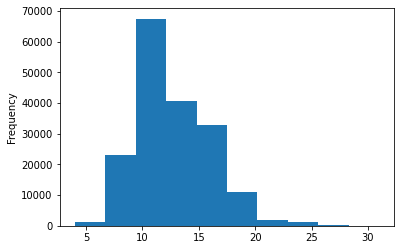

In [190]:
train_df['total_lines'].plot.hist()

In [191]:
train_sentences, test_sentences, val_sentences = train_df['text'].tolist(), test_df['text'].tolist(), val_df['text'].tolist()
len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [192]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Label encode and one hot encode labels

In [193]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_one_hot, val_labels_one_hot, test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [194]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_label_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_label_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [195]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Tfidf vectorizer based Naive Bayes

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model_0 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_0.fit(train_sentences, train_labels_label_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [197]:
predictions = model_0.predict(val_sentences)

In [198]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

accuracy_score(val_labels_label_encoded, predictions)

0.7218323844829869

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


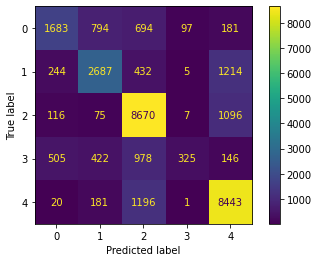

In [199]:
plot_confusion_matrix(model_0, val_sentences, val_labels_label_encoded)

In [200]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-15 17:45:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-15 17:45:41 (107 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [201]:
from helper_functions import calculate_results
baseline_results = calculate_results(val_labels_label_encoded, predictions)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing Data for deep seq models

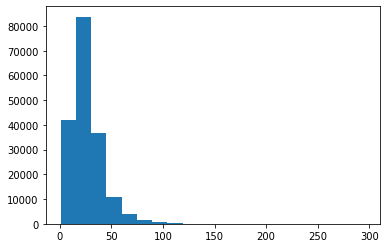

In [202]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sent_lens = [len(sentence.split()) for sentence in train_sentences]
#mean_sentence_length = np.round(np.mean([len(sentence.split()) for sentence in train_sentences]))
#mean_sentence_length_pow_2 = int(2**(np.ceil(np.log2(mean_sentence_length+1))))
#mean_sentence_length_pow_2
plt.hist(sent_lens, bins=20);

In [203]:
max(sent_lens)

296

In [204]:
np.mean(sent_lens)

26.338269273494777

In [205]:
# Taking 95% of sentence length as max_tokens for textvectorizer
out_seq_len = int(np.percentile(sent_lens, 95))
out_seq_len

55

In [206]:
# Taken from the paper
max_tokens = 68000

In [207]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = out_seq_len
)
text_vectorizer.adapt(train_sentences)

In [208]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

64841

In [209]:
import random
s = random.choice(train_sentences)
print(f"""
  Sentence: {s}\n
  Sentence length: {len(s.split())} \n
  Tokenized: {text_vectorizer(s)} \n
  Tokenized sentence length: {len(text_vectorizer(s))}
""")


  Sentence: in addition , the mean central keratometry and spherical and cylindrical refraction reduced significantly in both groups , and spherical aberration increased significantly in both groups .

  Sentence length: 27 

  Tokenized: [    5   333     2    57   681  9666     3  3867     3 26930  5624   191
    39     5    54    24     3  3867 15239    96    39     5    54    24
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] 

  Tokenized sentence length: 55



In [210]:
text_vectorizer(s), len(text_vectorizer(s))

(<tf.Tensor: shape=(55,), dtype=int64, numpy=
 array([    5,   333,     2,    57,   681,  9666,     3,  3867,     3,
        26930,  5624,   191,    39,     5,    54,    24,     3,  3867,
        15239,    96,    39,     5,    54,    24,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])>, 55)

In [211]:
embedding_dim = 128

token_embed = tf.keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    mask_zero = True, ## Makes computations faster by masking the padded elements in further layers
    name = "token_embedding")

In [212]:
vec = text_vectorizer(["I love TensorFlow",
                       "I am learning NLP with Deep learning in Keras"])
vec

<tf.Tensor: shape=(2, 55), dtype=int64, numpy=
array([[  389, 30315,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  389,  2651,   953,     1,     7,  1676,   953,     5,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [213]:
token_embed(vec)

<tf.Tensor: shape=(2, 55, 128), dtype=float32, numpy=
array([[[-0.03225855,  0.02596464, -0.04823958, ...,  0.02663824,
         -0.02479136, -0.01805776],
        [-0.00033183, -0.01631163,  0.02997153, ..., -0.0489395 ,
          0.00573034, -0.0189499 ],
        [ 0.01651477,  0.02097041, -0.04135453, ..., -0.04693854,
          0.01597636, -0.00045679],
        ...,
        [ 0.02566064, -0.02824952,  0.04827031, ..., -0.02329332,
         -0.01091429, -0.01699932],
        [ 0.02566064, -0.02824952,  0.04827031, ..., -0.02329332,
         -0.01091429, -0.01699932],
        [ 0.02566064, -0.02824952,  0.04827031, ..., -0.02329332,
         -0.01091429, -0.01699932]],

       [[-0.03225855,  0.02596464, -0.04823958, ...,  0.02663824,
         -0.02479136, -0.01805776],
        [-0.0457754 , -0.04355067,  0.02355523, ...,  0.04773131,
         -0.00450439, -0.03789667],
        [-0.04420748, -0.02273557,  0.03052977, ...,  0.02280035,
          0.03195905,  0.04289435],
        ...,


## Creating datasets Using tensorflow `tf.Data` API

So that the data loads faster

In [214]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [215]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [216]:
# Take TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model1: Conv1D

In [217]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
print(x.shape)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
print(x.shape)
x = tf.keras.layers.GlobalAvgPool1D()(x)
print(x.shape)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.summary()

(None, 55, 128)
(None, 55, 64)
(None, 64)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense) 

In [218]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = 'skimlit'

In [219]:
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history_1 = model_1.fit(
    train_dataset,
    steps_per_epoch = int(0.1*len(train_dataset)), # Dataset is large so lets train on 10% of the data
    epochs = 3,
    validation_data = val_dataset, 
    validation_steps = int(0.1*len(val_dataset)), # and validate on 10% of the data
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "conv1d_model")]
)

Saving TensorBoard log files to: skimlit/conv1d_model/20220815-174556
Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 0.9271 - categorical_accuracy: 0.6315 - val_loss: 0.6791 - val_categorical_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6477 - categorical_accuracy: 0.7612 - val_loss: 0.6271 - val_categorical_accuracy: 0.7756
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6110 - categorical_accuracy: 0.7779 - val_loss: 0.5922 - val_categorical_accuracy: 0.7886


In [220]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5921 - categorical_accuracy: 0.7886


[0.5921058058738708, 0.7885939478874207]

In [221]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs.shape, model_1_pred_probs

((30212, 5),
 array([[4.7879151e-01, 1.2225133e-01, 4.3276187e-02, 3.3677897e-01,
         1.8901955e-02],
        [4.3585354e-01, 2.9115707e-01, 1.2703032e-02, 2.5099131e-01,
         9.2950119e-03],
        [1.4068525e-01, 5.1698014e-03, 1.1120769e-03, 8.5298723e-01,
         4.5682504e-05],
        ...,
        [7.0116412e-06, 5.9814501e-04, 5.9727125e-04, 4.9436153e-06,
         9.9879265e-01],
        [4.4138275e-02, 4.9635887e-01, 9.1668427e-02, 4.6624333e-02,
         3.2121006e-01],
        [1.5222035e-01, 7.1034300e-01, 6.6276290e-02, 3.6612205e-02,
         3.4548193e-02]], dtype=float32))

In [222]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:3], model_1_pred_probs[:3]

(<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 3])>,
 array([[4.7879151e-01, 1.2225133e-01, 4.3276187e-02, 3.3677897e-01,
         1.8901955e-02],
        [4.3585354e-01, 2.9115707e-01, 1.2703032e-02, 2.5099131e-01,
         9.2950119e-03],
        [1.4068525e-01, 5.1698014e-03, 1.1120769e-03, 8.5298723e-01,
         4.5682504e-05]], dtype=float32))

In [223]:
results_1 = calculate_results(val_labels_label_encoded, model_1_preds)
results_1

{'accuracy': 78.85939361842976,
 'f1': 0.7863668613514708,
 'precision': 0.7853211365763835,
 'recall': 0.7885939361842976}

In [224]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction Transfer Learning using Universal Sentence Encoder
The paper uses Glove Embedding, but we'll use modern version of embedding (USE)

https://tfhub.dev/google/universal-sentence-encoder/4 

In [225]:
import tensorflow_hub as hub

In [226]:
tfhub_embed_layer = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                   trainable=False,
                                   name='use_encoder')

In [227]:
random_sentence = random.choice(train_sentences)
print(f"""
Sentence before USE embedding: \n
{random_sentence} \n
Sentence after USE embedding:
{tfhub_embed_layer([random_sentence])} \n
Size of sentence {tfhub_embed_layer([random_sentence]).shape}
""")


Sentence before USE embedding: 

the rate and severity of adverse events were similar in both treatment groups . 

Sentence after USE embedding:
[[-1.30548021e-02 -3.91617566e-02  1.32419700e-02  3.08459830e-02
   1.31148994e-02 -3.17953043e-02 -3.71444896e-02 -5.16919903e-02
  -3.38001139e-02  6.53157830e-02  9.46115851e-02 -4.22636978e-02
   1.55190071e-02 -1.13267442e-02 -4.86235917e-02 -5.33398166e-02
  -8.72746035e-02 -5.22964373e-02  4.02633883e-02  3.85742299e-02
   5.42251468e-02  3.29414718e-02 -5.95247783e-02 -5.54202832e-02
   2.28735842e-02 -6.06376259e-03  1.79400202e-02  3.10302563e-02
  -1.93590652e-02  6.65289313e-02  2.43888237e-02  9.77253094e-02
  -2.65943501e-02  6.76592290e-02 -4.04771417e-03 -1.30690180e-03
   3.40148956e-02 -4.57478538e-02  6.39128461e-02 -2.48437226e-02
  -2.38456577e-02  3.54064479e-02  3.10617201e-02  2.39121001e-02
   1.06232315e-02  6.07242202e-03 -3.40540172e-03  6.42082514e-03
   5.46036996e-02 -1.53608632e-03 -4.16310914e-02  1.76500343e

In [228]:
model_2 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=[], dtype=tf.string),
        tfhub_embed_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ]
)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [229]:
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history_2 = model_2.fit(
    train_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1*len(train_dataset)),
    validation_data = val_dataset,
    validation_steps = int(0.1*len(val_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             'use_pretrained_embedding_model')]
)

Saving TensorBoard log files to: skimlit/use_pretrained_embedding_model/20220815-174621
Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9176 - categorical_accuracy: 0.6467 - val_loss: 0.7992 - val_categorical_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7716 - categorical_accuracy: 0.6996 - val_loss: 0.7570 - val_categorical_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7557 - categorical_accuracy: 0.7094 - val_loss: 0.7425 - val_categorical_accuracy: 0.7111


In [230]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7449 - categorical_accuracy: 0.7123


[0.744906485080719, 0.7122666239738464]

In [231]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred_probs.shape, model_2_preds.shape

((30212, 5), TensorShape([30212]))

In [232]:
results_2 = calculate_results(val_labels_label_encoded, model_2_preds)
results_2

{'accuracy': 71.2266649013637,
 'f1': 0.7094251499136652,
 'precision': 0.7126552051845942,
 'recall': 0.712266649013637}

In [233]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 3 - Character level embedding based model

### Creating character level tokenizer

In [234]:
def split_chars(text):
  return " ".join(list(text))

In [235]:
split_chars("I love Tensorflow")

'I   l o v e   T e n s o r f l o w'

In [236]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [237]:
## Average characted length
char_lens = [len(char) for char in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

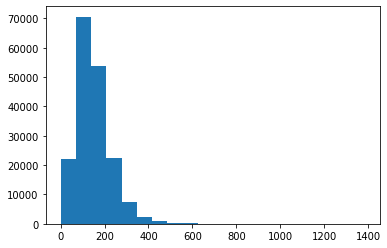

In [238]:
plt.hist(char_lens, bins=20);

In [239]:
output_seq_char_len = np.percentile(char_lens, 95)
output_seq_char_len

290.0

In [240]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [241]:
## Create character level text vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length = int(output_seq_char_len),
    name = "char_vectorizer"
)
char_vectorizer.adapt(train_chars)

In [242]:
words_in_char_vocab = char_vectorizer.get_vocabulary()
len(words_in_char_vocab), words_in_char_vocab

(28,
 ['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'])

In [243]:
random_sentence = "I l o v e T e n s o r f l o w"
char_vectorizer(random_sentence)

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 4, 12,  7, 21,  2,  3,  2,  6,  9,  7,  8, 17, 12,  7, 20,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [244]:
random_sentence = random.choice(train_chars)
char_vectorizer(random_sentence)

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 3, 13,  2, 14,  8,  4, 15,  5,  8, 19,  2,  6, 10, 14,  7,  4,  6,
        3, 20,  5,  9,  7, 21,  2,  8,  5, 12, 12,  9, 16,  8, 21,  4, 21,
        5, 12,  5,  6, 10,  3, 13,  2, 14,  8,  4, 15,  5,  8, 19, 13, 19,
       14,  7,  3, 13,  2,  9,  4,  9, 20,  5,  9,  3, 13,  2,  2, 24,  4,
        9,  3,  2,  6, 11,  2,  7, 17,  5,  9,  4, 18,  6,  4, 17,  4, 11,
        5,  6,  3,  4,  6,  3,  2,  8,  5, 11,  3,  4,  7,  6, 22,  2,  3,
       20,  2,  2,  6,  3, 13,  2,  9,  2,  8, 16, 15, 14,  8,  7,  3,  2,
        4,  6,  3,  2,  9,  3, 11, 12,  5,  9,  9,  4, 17,  4, 11,  5,  3,
        4,  7,  6,  5,  6, 10,  3,  8,  2,  5,  3, 15,  2,  6,  3,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

### Character level embedding

In [245]:
char_embed = tf.keras.layers.Embedding(
    input_dim = NUM_CHAR_TOKENS,
    output_dim = 25, # Taken from paper
    mask_zero = True,
    name = 'char_embed'
)

In [246]:
random_sentence = random.choice(train_chars)
vec_sentence = char_vectorizer(random_sentence)
print(f"""
Sentence before vectorization: \n
{random_sentence} \n
Sentence after vectorization: \n
{char_vectorizer(random_sentence)} \n
Sentence after character embedding: \n
{char_embed(vec_sentence)} \m
Size of sentence after embedding: \n
{(char_embed(vec_sentence)).shape}
""")


Sentence before vectorization: 

u l c e r s   o f   t h e   h e e l   i n   d i a b e t e s   a r e   t h e   s o u r c e   o f   c o n s i d e r a b l e   s u f f e r i n g   a n d   c o s t   . 

Sentence after vectorization: 

[16 12 11  2  8  9  7 17  3 13  2 13  2  2 12  4  6 10  4  5 22  2  3  2
  9  5  8  2  3 13  2  9  7 16  8 11  2  7 17 11  7  6  9  4 10  2  8  5
 22 12  2  9 16 17 17  2  8  4  6 18  5  6 10 11  7  9  3  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  

In [247]:
### Model 3
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='char_embedding_conv1d_model')
model_3.summary()

Model: "char_embedding_conv1d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 5) 

### Creating datasets for char data

In [248]:
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [249]:
train_char_datasets

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Compile and fit the model

In [250]:
model_3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

history_3 = model_3.fit(
    train_char_datasets,
    epochs = 3,
    validation_data = val_char_datasets,
    steps_per_epoch = int(0.1*len(train_char_datasets)),
    validation_steps = int(0.1*len(val_char_datasets)),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "conv1d_char_level_embedding")]
)

Saving TensorBoard log files to: skimlit/conv1d_char_level_embedding/20220815-174743
Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2719 - categorical_accuracy: 0.4872 - val_loss: 1.0422 - val_categorical_accuracy: 0.5834
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0010 - categorical_accuracy: 0.5991 - val_loss: 0.9385 - val_categorical_accuracy: 0.6280
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9215 - categorical_accuracy: 0.6416 - val_loss: 0.8702 - val_categorical_accuracy: 0.6649


In [251]:
model_3.evaluate(val_char_datasets)

945/945 [==============================] - 3s 4ms/step - loss: 0.8889 - categorical_accuracy: 0.6592


[0.888910710811615, 0.6592413783073425]

In [252]:
prediction_probs = model_3.predict(val_char_datasets)
predictions = tf.argmax(prediction_probs, axis=1)
results_3 = calculate_results(val_labels_label_encoded, predictions)
results_3

{'accuracy': 65.924136104859,
 'f1': 0.6504390498952124,
 'precision': 0.6593184865466561,
 'recall': 0.65924136104859}

## Model 4: Pretrained token embedding + character embedding - Multimodal model

1. Create token level embedding model - similar to `model_1`
2. Create character level embedding model - similar to `model_3`
3. Combile 1 and 2 with `tf.keras.layers.Concatenate`
4. Build a series of outputs on top of 3 (from figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf)
5. Create model which takes token and sequence level embeddings as inputs and returns sequence level predictions

### Create token model

In [253]:
# Step 1.
# Token inputs for token embeddings
token_inputs = tf.keras.Input(shape=[], dtype=tf.string)

# Token embedding layer that we initialized earlier in model_2
token_embedding = tfhub_embed_layer(token_inputs)

# Token outputs -> pass the tokens through token embedding layer
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embedding)

# Create model from token inputs and token outputs
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs, name = "token_embedding_model")

token_model.summary()

Model: "token_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None,)]                 0         
                                                                 
 use_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


### Create token model

In [254]:
# Step 2.

# Inputs for char level embedding
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Char level vectorizer
char_vectors = char_vectorizer(char_inputs)

# Char level embedding
char_embedding = char_embed(char_vectors)

# BiLSTM (from paper)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu'))(char_embedding)

# Character level embedding model
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_outputs, name='char_embedding_model')
char_model.summary()

Model: "char_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 bidirectional_1 (Bidirectio  (None, 48)               9600      
 nal)                                                            
                                                                 
Total params: 11,350
Trainable params: 11,350
Non-trainable params: 0
_________________________________________________________________


### Concatenate token and char models

In [255]:
# Step 3. Concatenate token and char level embedding models outputs
token_char_concat = tf.keras.layers.Concatenate(name = 'token_char_hybrid')([token_model.output, char_model.output])
token_char_concat

<KerasTensor: shape=(None, 176) dtype=float32 (created by layer 'token_char_hybrid')>

### Apply some layers and output layers

In [256]:
# Step 4: Apply Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dropout

<KerasTensor: shape=(None, 176) dtype=float32 (created by layer 'dropout_6')>

In [257]:
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
combined_dense

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_14')>

In [258]:
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
final_output = tf.keras.layers.Dense(num_classes, activation='softmax')(final_dropout)
final_output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_15')>

In [259]:
# Step 5. Construct model with char and token inputs and final_outputs

### Create model

In [260]:
model_4 = tf.keras.Model(inputs = [token_model.inputs, char_model.inputs],
                         outputs = final_output)
model_4.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_10[0][0]']               
 tion)                                                                                            
                                                                                                  
 use_encoder (KerasLayer)       (None, 512)          256797824   ['input_9[0][0]']          

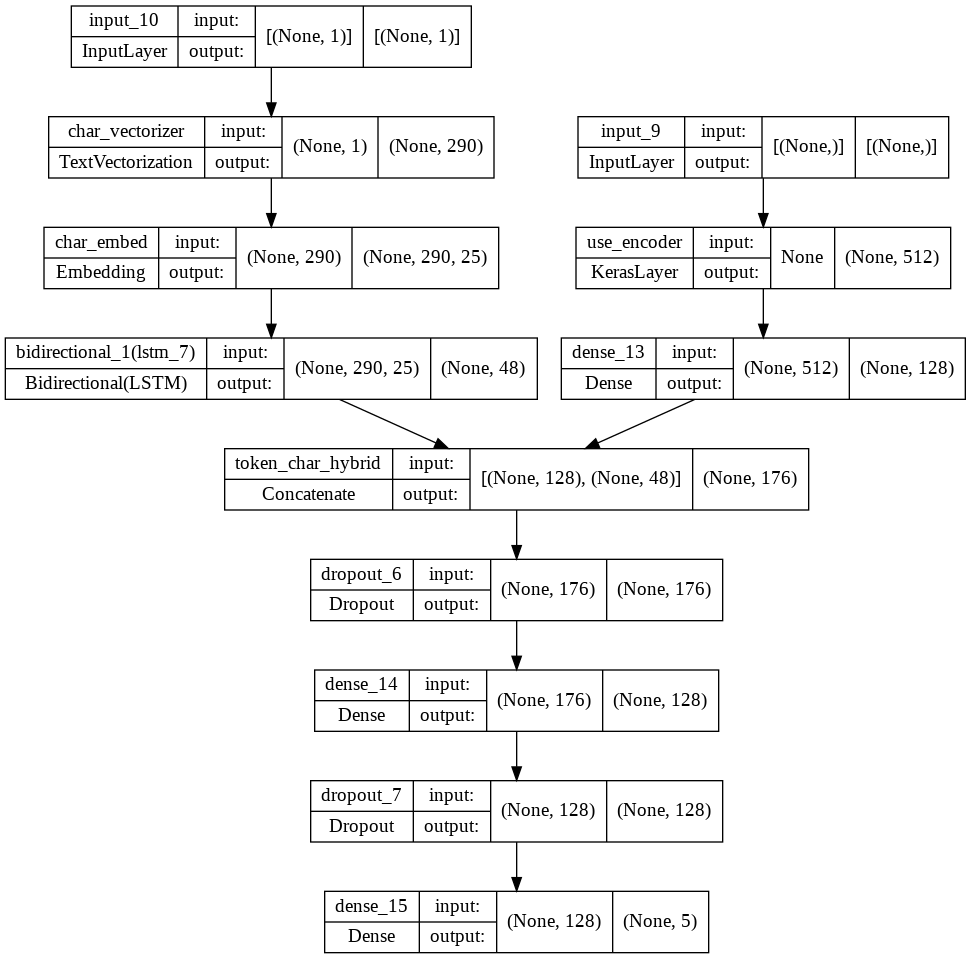

In [261]:
tf.keras.utils.plot_model(model_4, show_shapes = True)

In [262]:
### Compile the model
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

### Create datasets for multi-modal model

In [263]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [264]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-48b3b836-8fbe-6854-9d07-f7c98e41d2b5)


In [287]:
history_4 = model_4.fit(
    train_token_char_dataset, # This consists of token embedding, char embedding and label tuples
    epochs = 3,
    steps_per_epoch = int(0.1*len(train_token_char_dataset)),
    validation_data = val_token_char_dataset,
    validation_steps = int(0.1*len(val_token_char_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                             "token_char_embedding_hybrid_multimodal_model")]
)

Saving TensorBoard log files to: skimlit/token_char_embedding_hybrid_multimodal_model/20220815-175852
Epoch 1/3
190/562 [=========>....................] - ETA: 7:58 - loss: 0.9217 - categorical_accuracy: 0.6380

KeyboardInterrupt: ignored

In [ ]:
model_4.evaluate(val_token_char_dataset)

In [ ]:
predictions = model_4.predict(val_token_char_dataset)
model_4_pred_labels = tf.argmax(predictions, axis=1)
results_4 = calculate_results(val_labels_label_encoded, model_4_pred_labels)
results_4

In [ ]:
results_1

## Model 5: Character embedding, token embedding and positional embedding
We know that the OBJECTIVE will appear before a RESULT or CONCLUSION in the abstract, so we can use this information and feed it to the model so that model can learn and improve.

For this we'll have to encode the positional information by encoding it. Known as position encoding.

In [266]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


### Encode line_number column

In [267]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

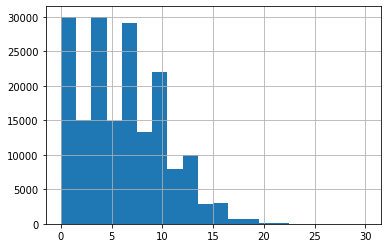

In [268]:
train_df['line_number'].hist(bins = 20);

In [269]:
# Since most of the sentence lengths are less than 15, we can one-hot encode with a depth of 15
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_number_one_hot =  tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_number_one_hot[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### Encode total_lines feature

In [270]:
train_df['total_lines'].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

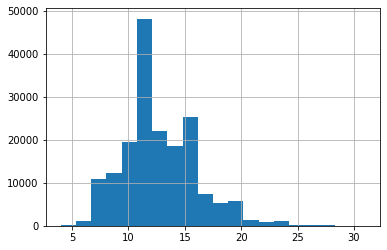

In [271]:
train_df['total_lines'].hist(bins=20);

In [272]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
     

### Building a tribrid embedding model
1. Create token level embedding model
2. Create character level embedding model
3. Create a model for `line_number` feature
4. Create a model for `total_lines` feature
5. Concatenate(1, 2)
6. Concatenate(3, 4, 5)
7. Create a model that takes 1,2,3,4 as input and outputs a label probability


In [273]:
# 1. Token Model
token_inputs = tf.keras.layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
token_embeddings = tfhub_embed_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu", name = "token_outputs")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name="token_embedding_model")
token_model.summary()

Model: "token_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_inputs (InputLayer)   [(None,)]                 0         
                                                                 
 use_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 token_outputs (Dense)       (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


In [274]:
# 2. Character model
char_inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name = "character_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name="character_outputs")(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_outputs, name="char_embedding_model")
char_model.summary()

Model: "char_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 character_inputs (InputLaye  [(None, 1)]              0         
 r)                                                              
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 character_outputs (Bidirect  (None, 48)               9600      
 ional)                                                          
                                                                 
Total params: 11,350
Trainable params: 11,350
Non-trainable params: 0
__________________________________________

In [275]:
# 3 and 4. -> Dense layer encoding for line_number and total_lines
inputs_line_number = tf.keras.layers.Input(shape=(len(train_line_number_one_hot[0]),), dtype=tf.float32, name = "line_number_input")
outputs_line_number = tf.keras.layers.Dense(32, activation='relu', name='line_number_output')(inputs_line_number)
line_number_model = tf.keras.Model(inputs = inputs_line_number, outputs = outputs_line_number, name = "line_number_model")
line_number_model.summary()

inputs_total_lines = tf.keras.layers.Input(shape=(len(train_total_lines_one_hot[0]),), dtype=tf.float32, name = "total_lines_input")
outputs_total_lines = tf.keras.layers.Dense(32, activation='relu', name='total_lines_output')(inputs_total_lines)
total_lines_model = tf.keras.Model(inputs = inputs_total_lines, outputs = outputs_total_lines, name = "total_lines_model")
total_lines_model.summary()

Model: "line_number_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 line_number_input (InputLay  [(None, 15)]             0         
 er)                                                             
                                                                 
 line_number_output (Dense)  (None, 32)                512       
                                                                 
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________
Model: "total_lines_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 total_lines_input (InputLay  [(None, 20)]             0         
 er)                                                             
                                                                 
 total_lines_output (Den

In [276]:
## 5. Concatenate 1 and 2:
token_char_level_embeddings = tf.keras.layers.Concatenate(name = "concatenate_token_char_model")([token_model.output, char_model.output])
z = tf.keras.layers.Dense(256, activation='relu', name='dense_after_embedding_concat')(token_char_level_embeddings)
z = tf.keras.layers.Dropout(0.5, name = 'dropout_after_embedding_concat')(z)
z

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dropout_after_embedding_concat')>

In [277]:
## 6. Concatenate 3, 4, 5
concate_all_embeddings = tf.keras.layers.Concatenate(name="concatenate_all_embeddings")(
    [line_number_model.output,
     total_lines_model.output,
     z]
)
concate_all_embeddings

<KerasTensor: shape=(None, 320) dtype=float32 (created by layer 'concatenate_all_embeddings')>

In [278]:
# 7. concate_all_embeddings -> (None, 240) -> Add some dense and dropout layers to finally have a size 5 dense layer
#dropout_after_embeddings = tf.keras.layers.Dropout(0.5)(concate_all_embeddings)
#dense_after_embeddings = tf.keras.layers.Dense(128, activation='relu')(dropout_after_embeddings)
#final_dropout = tf.keras.layers.Dropout(0.5)(dense_after_embeddings)

final_outputs = tf.keras.layers.Dense(5, activation='softmax', name='final_output')(concate_all_embeddings)

## 8. Create model
model_5 = tf.keras.Model(
    inputs = [line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
    outputs = final_outputs,
    name = "tribrid_embedding_model"
)

model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['character_inputs[0][0]']       
 tion)                                                                                            
                                                                                                  
 use_encoder (KerasLayer)       (None, 512)          256797824   ['token_inp

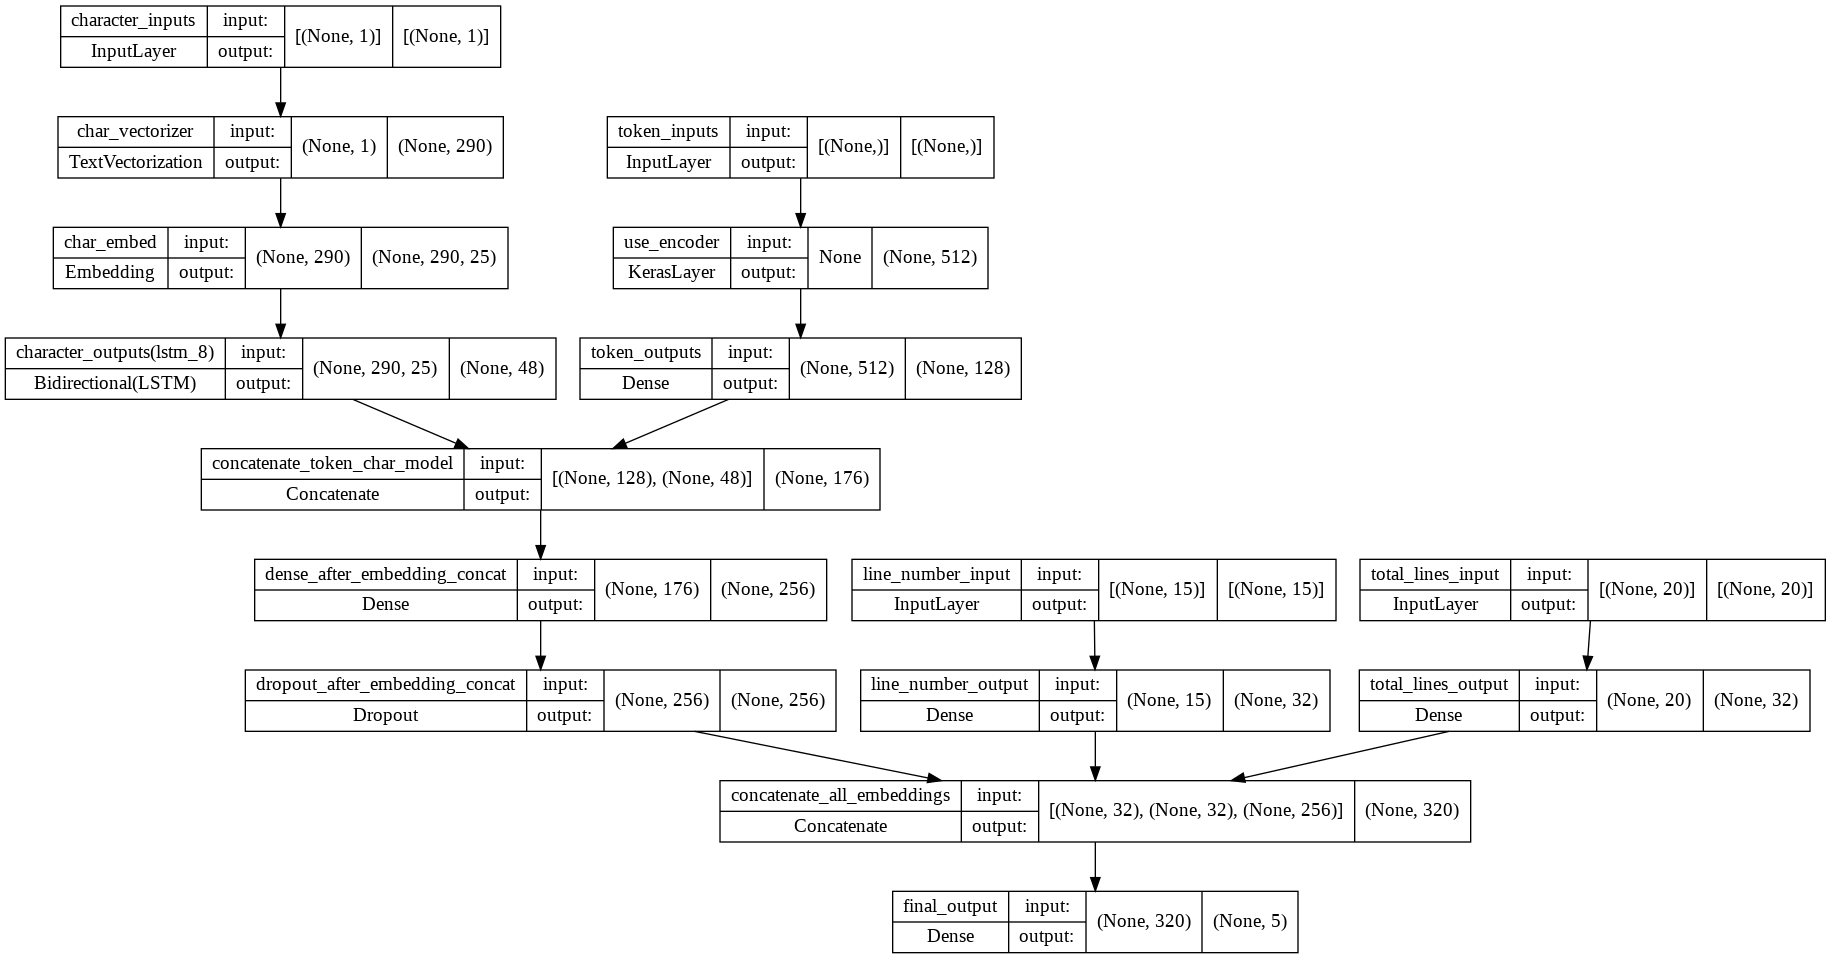

In [279]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

### Compile model with label smoothing
Meaning of label smoothing

Say model is very confident about its predictions and pred probs are
`[0.0, 0.0, 1.0, 0.0, 0.0]` then the model might get stuck with this target label

Label smoothing smooths out these targets to something like below
`[0.01, 0.01, 0.96, 0.01, 0.01]`.

It destributes the max prob values to other classes

In [280]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps prevent overfitting
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)

### Create tf.data.Dataset for multiple inputs

In [281]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [282]:
train_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fit the model

In [283]:
history_5 = model_5.fit(
    train_char_token_pos_dataset,
    epochs = 3,
    validation_data = val_char_token_pos_dataset,
    steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
    validation_steps = int(0.1*len(val_char_token_pos_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
                                "tribrid_model_with_pos_embedding")]
)

Saving TensorBoard log files to: skimlit/tribrid_model_with_pos_embedding/20220815-175206
Epoch 1/3
562/562 [==============================] - 40s 55ms/step - loss: 1.0988 - categorical_accuracy: 0.7251 - val_loss: 0.9792 - val_categorical_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.9675 - categorical_accuracy: 0.8149 - val_loss: 0.9502 - val_categorical_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9522 - categorical_accuracy: 0.8234 - val_loss: 0.9391 - val_categorical_accuracy: 0.8285


In [284]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.9382 - categorical_accuracy: 0.8332


[0.9381802082061768, 0.8332119584083557]

In [285]:
pred_probs = model_5.predict(val_char_token_pos_dataset)
preds = tf.argmax(pred_probs, axis=1)
results_5 = calculate_results(val_labels_label_encoded, preds)
results_5

{'accuracy': 83.32119687541373,
 'f1': 0.8322516926225434,
 'precision': 0.8319997267869474,
 'recall': 0.8332119687541374}

In [286]:
results_3

{'accuracy': 65.924136104859,
 'f1': 0.6504390498952124,
 'precision': 0.6593184865466561,
 'recall': 0.65924136104859}